This notebook runs a Convolutional Neural Network and Random Forest to predict the binned yards gained. The CNN requires TensorFlow. This was originally made in Google Colab.

# Set up Environment

In [0]:
import pickle
import pandas as pd
import numpy as np
# plots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # normalizing
import itertools
# Random Forest
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance # feature importance
# Convolutional Neural Network
import keras
from keras_radam import RAdam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import metrics
from sklearn.model_selection import train_test_split
# Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
 #to run this you need the data(2).pkl file in your Google Drive and to have your Google Drive mounted to the Colab Notebook
data = pd.read_pickle('/content/drive/My Drive/data(2).pkl')

## Data Conversion
Most machine learning algorithms require numeric data
 - convert object and string variables to numeric
 - use dummy variables

### Game Clock to Seconds

In [0]:
## convert the game clock to seconds
def strtoseconds(txt):
    # get the different parts of the time
    txt = txt.split(':')
    # new time will be in seconds
    # minutes * 60 + seconds + microseconds/60
    new_time = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return new_time
# don't run this if you load data(1).pkl
data['gameclock'] = data['gameclock'].apply(strtoseconds)

### OL to int

In [0]:
# convert ol ot integer
data['ol'] = data['ol'].astype(int)

### Columns to Keep for Models
These include numeric columns and categorical columns to be converted with dummy variables

In [0]:
cols_to_keep = ['team',
 's',
 'a',
 'dis',
 'orientation',
 'dir',
 'season',
 'yardline',
 'quarter',
 'gameclock',
 'possessionteam',
 'down',
 'distance',
 'fieldposition',
 'homescorebeforeplay',
 'visitorscorebeforeplay',
 'offenseformation',
 'offensepersonnel',
 'defendersinthebox',
 'defensepersonnel',
 #'yards', # this is the target variable - remove this for the test set
 'playerheight',
 'playerweight',
 'playercollegename',
 'position',
 'hometeamabbr',
 'visitorteamabbr',
 'week',
 'age',
 'time_since_snap',
 'rusher',
 'rushx',
 'rushy',
 'disttorush',
 'teamidentity',
 'min_distancetorusher',
 'ol_d',
 'dl',
 'lb',
 'db',
 'rb_d',
 'qb',
 'ol',
 'rb',
 'te',
 'wr',
 'dl_o',
 'lb_o',
 'db_o',
 'yardfromowngoal',
 'x_standard',
 'y_standard',
 'avgyardspergame',
 'x_handoff',
 'y_handoff',
 'offense',
 'eff_downfield_acc',
 'eff_crossfield_acc',
 'rushteamwinning',
 'playerblocked',
 'total_playersblocked_revised']
 #'yards_binned']

In [22]:
data['yards_binned'].unique()

array(['8 to 10', '0 to 3', '4 to 7', '-3 to -1', '11 to 15', '16 to 25',
       '-9 to -4', '26+', '-10 or less'], dtype=object)

In [0]:
# label bins need to be in integers for neural network to get dummy variables for the label array
bin_int = {'-10 or less':0,
           '-9 to -4':1,
           '-3 to -1':2,
           '0 to 3':3,
           '4 to 7':4,
           '8 to 10':5,
           '11 to 15':6,
           '16 to 25':7,
           '26+':8}
data['yards_bin_int'] = data['yards_binned'].map(bin_int)
bin_yard_names = list(bin_int.keys())

### Distribution of Binned Yards

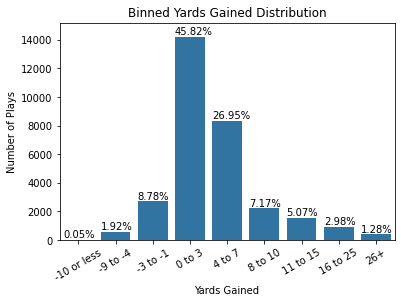

In [6]:
# distribution of binned yards
df = pd.DataFrame(data['yards_binned'].value_counts())
df['yards'] = df.index
order = ['-10 or less', '-9 to -4', '-3 to -1', '0 to 3', '4 to 7', '8 to 10', '11 to 15', '16 to 25', '26+']
df = df.reindex(order)
df['yards_binned'] = df['yards_binned']/22
df['prop'] = round(df['yards_binned']/df['yards_binned'].sum()*100,2)
#print(df)
sns.barplot(x = 'yards', y = 'yards_binned', data = df, color = 'tab:blue')
plt.ylabel('Number of Plays')
plt.xlabel('Yards Gained')
plt.title('Binned Yards Gained Distribution')
plt.xticks(rotation = 30)
for i in np.arange(len(df)):
    plt.text(x = i - 0.4, 
             y = df['yards_binned'][i]+150, 
             s = str(df['prop'][i]) + '%')
plt.ylim(0, df['yards_binned'].max()+1000)
plt.show()
del df

### Get Dummy Variables for Categorical

In [0]:
### Get dummy variables for categorical variables (object type)
num_data = data[cols_to_keep]
num_data = pd.get_dummies(num_data)

In [0]:
num_data.fillna(-999, inplace = True)

## Train and Test Sets

In [31]:
## use 2017 and 2018 to predict 2019

# input variables
trainX = num_data.loc[num_data['season'] != 2019]
testX = num_data.loc[num_data['season'] == 2019]
# labels
trainY = data.loc[data['season'] != 2019]['yards']
testY = data.loc[data['season'] == 2019]['yards']
# binned labels
bin_trainY = data.loc[data['season'] != 2019]['yards_bin_int']
bin_testY = data.loc[data['season'] == 2019]['yards_bin_int']
# drop labels from input variables
#trainX.drop('yards', axis = 1, inplace = True)
#trainY.drop('yards', axis = 1, inplace = True)

print('# of Train Plays: {}   # of Test Plays: {}'.format(int(trainX.shape[0]/22), int(testX.shape[0]/22)))
print('# of Train Labels: {}  # of Test Labels: {}'.format(int(trainY.shape[0]/22), int(testY.shape[0]/22)))
print('# of Train Bins: {}  # of Test Bins: {}'.format(int(bin_trainY.shape[0]/22), int(bin_testY.shape[0]/22)))
print('All Plays Covered: {}'.format(trainX.shape[0] + testY.shape[0] == num_data.shape[0]))

# of Train Plays: 23171   # of Test Plays: 7836
# of Train Labels: 23171  # of Test Labels: 7836
# of Train Bins: 23171  # of Test Bins: 7836
All Plays Covered: True


In [0]:
# drop categorical features - only want numeric
cat_features = []
for col in trainX.columns:
  if (trainX[col].dtype == 'object'):
    cat_features.append(col)
# drop from train and test sets
trainX = trainX.drop(cat_features, axis = 1)
testX = testX.drop(cat_features, axis = 1)

In [0]:
# keep all columns with a standard deviation not 0 - only columns
# with variance
players_col = []
for col in num_data.columns:
    if trainX[col][:22].std()!=0:
        players_col.append(col)

## Evaluation Metrics

### Plot Confusion Matrix

In [0]:
def plot_CM(cm, # confusion_matrix object
            classes, # class labels
            normalize = False, # normalize values
            title = 'Confusion Matrix',
            cmap = 'PuBu'):
  '''
  ouputs: confusion matrix of predicted vs actual labels
  '''
  plt.figure(figsize = (7, 7))
  # plot confusion matrix
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap) 
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 90)
  plt.yticks(tick_marks, classes)
  # normalize the values (%)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    cm = np.round(cm, 2)
  # set threshold for text color
  # if count < half max - white, > half max - black
  thresh = cm.max()/2
  # annotate confusion matrix
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')


### Plot Validation and Loss Curves for CNN

In [0]:
# plot train curve function
def plot_train_curve(history):
    # get training accuracy
    accuracy = history.history['accuracy']
    # get test accuracy
    val_accuracy = history.history['val_accuracy']
    # train loss
    loss = history.history['loss']
    # test los
    val_loss = history.history['val_loss']
    # enumerate each epoch 0 to number of ephochs 
    epochs = range(len(accuracy))
        
    plt.figure(figsize = (8, 8/1.618))
    # training accuracy line plot
    plt.plot(epochs, accuracy, marker = 'o', 
             c = 'tab:orange', label = 'Training accuracy')
    # test accuracy line plot
    plt.plot(epochs, val_accuracy, marker = 'D', 
             c = 'tab:blue', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.xlim(0, len(epochs))
    plt.legend()
    plt.figure(figsize = (8, 8/1.618))
    # training loss line plot
    plt.plot(epochs, loss, marker = 'o', 
             c = 'tab:orange', label = 'Training loss')
    # test loss line plot
    plt.plot(epochs, val_loss, marker = 'D', 
             c = 'tab:blue', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.xlim(0,len(epochs))
    plt.legend()
    plt.show()

# Convolutional Neural Network
Requires Binned Yards for Prediction

## Reshape Data

In [0]:
from keras.utils import np_utils # categorical variable

In [36]:
# reshape the train and test sets to be arrays 
# shape of array should be # of plays by number of features kept * 22
cnn_trainX = np.array(trainX[players_col]).reshape(-1, len(players_col)*22)
cnn_testX = np.array(testX[players_col]).reshape(-1, len(players_col)*22)
print(cnn_trainX.shape)
print(cnn_testX.shape)


(23171, 1276)
(7836, 1276)


In [0]:
# gets all the columns that are used as features
play_col = trainX.drop(players_col, axis = 1).columns
# generate an array of 0s that is number of plays by number of features
xtrain_play_col = np.zeros(shape = (cnn_trainX.shape[0], len(play_col)))
xtest_play_col = np.zeros(shape = (cnn_testX.shape[0], len(play_col)))
# fill in the array
for i, col in enumerate(play_col):
  xtrain_play_col[:, i] = trainX[col][::22]
  xtest_play_col[:, i] = testX[col][::22]

In [0]:
# put together training array with features
cnn_trainX = np.concatenate([cnn_trainX, xtrain_play_col], axis = 1)
cnn_testX = np.concatenate([cnn_testX, xtest_play_col], axis = 1)
# create the label arrays
# create an array of zeros of shape number of plays by 9 - number of bins
# use [::22] to get all rows and cols but count by 22 (play level)
# all yards
cnn_trainY = np_utils.to_categorical(trainY)[::22]
cnn_testY = np_utils.to_categorical(testY)[::22]
# binned yard labels
bin_cnn_trainY = np_utils.to_categorical(bin_trainY)[::22]
bin_cnn_testY = np_utils.to_categorical(bin_testY)[::22]


In [0]:
#from sklearn.preprocessing import MinMaxScaler # normalizing
# normalize the data to be between 0 and 1
scaler = MinMaxScaler()
cnn_trainX = scaler.fit_transform(cnn_trainX)
cnn_testX = scaler.fit_transform(cnn_testX)
#norm_data = pd.DataFrame(scaler.fit_transform(num_data), 
 #                       columns = num_data.columns)

In [144]:
print('train set: ', cnn_trainX.shape)
print('train labels: ', bin_cnn_trainY.shape)
print('test set: ', cnn_testX.shape)
print('test labels: ', bin_cnn_testY.shape)

train set:  (23171, 5518)
train labels:  (23171, 9)
test set:  (7836, 5518)
test labels:  (7836, 9)


## Define the Model

In [0]:
def get_model():
    x = keras.layers.Input(shape=[cnn_trainX.shape[1]])
    # convolution layer 1
    fc1 = keras.layers.Dense(units = 450, input_shape=[cnn_trainX.shape[1]])(x)
    # activation function (relu)
    act1 = keras.layers.PReLU()(fc1)
    # batch normalization
    bn1 = keras.layers.BatchNormalization()(act1)
    # randomly drop 55% of neurons
    dp1 = keras.layers.Dropout(0.55)(bn1)
    # augment data to avoid overfitting
    gn1 = keras.layers.GaussianNoise(0.15)(dp1)
    # join it together
    concat1 = keras.layers.Concatenate()([x, gn1])
    # convolution layer 2
    fc2 = keras.layers.Dense(units = 600)(concat1)
    # activation function (relu)
    act2 = keras.layers.PReLU()(fc2)
    # batch normalization
    bn2 = keras.layers.BatchNormalization()(act2)
    # randomly drop 55% of neurons
    dp2 = keras.layers.Dropout(0.55)(bn2)
    # augment data to avoid overfitting
    gn2 = keras.layers.GaussianNoise(0.15)(dp2)
    # join the layer together
    concat2 = keras.layers.Concatenate()([concat1, gn2])
    # convolution layer 3
    fc3 = keras.layers.Dense(units=400)(concat2)
    act3 = keras.layers.PReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.55)(bn3)
    gn3 = keras.layers.GaussianNoise(0.15)(dp3)
    concat3 = keras.layers.Concatenate([concat2, gn3])
    # final fully connected layer
    # use softmax activation for predictions
    output = keras.layers.Dense(units = 9, activation = 'softmax')(concat2)
    model = keras.models.Model(inputs = [x], outputs = [output])
    return model


## Compile and Fit the Model

In [188]:
# define the model
bin_model = get_model()
# compile the model
bin_model.compile(optimizer = RAdam(warmup_proportion = 0.1, min_lr = 0.001), 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
# define an early stopping feature 
er = EarlyStopping(patience = 20, # stops after 20 epochs with no decrease in loss
                      min_delta = 0.001, # minimum change in loss to keep running 
                       restore_best_weights = True, 
                       monitor = 'val_loss')
batch_size = 100 # put in 100 plays at a time
# fit the model on the train set and use it on validation set
history = bin_model.fit(cnn_trainX, bin_cnn_trainY, epochs = 200, 
              callbacks = [er], 
              validation_data = [cnn_testX, bin_cnn_testY],
              verbose = 2, 
              batch_size = batch_size)


Train on 23171 samples, validate on 7836 samples
Epoch 1/200
 - 3s - loss: 2.4030 - accuracy: 0.1334 - val_loss: 2.1149 - val_accuracy: 0.2014
Epoch 2/200
 - 2s - loss: 2.4030 - accuracy: 0.1353 - val_loss: 2.1377 - val_accuracy: 0.1893
Epoch 3/200
 - 2s - loss: 2.4047 - accuracy: 0.1373 - val_loss: 2.1796 - val_accuracy: 0.1736
Epoch 4/200
 - 2s - loss: 2.4109 - accuracy: 0.1339 - val_loss: 2.1927 - val_accuracy: 0.1688
Epoch 5/200
 - 2s - loss: 2.3944 - accuracy: 0.1381 - val_loss: 2.1981 - val_accuracy: 0.1644
Epoch 6/200
 - 2s - loss: 2.4107 - accuracy: 0.1322 - val_loss: 2.1929 - val_accuracy: 0.1690
Epoch 7/200
 - 2s - loss: 2.4096 - accuracy: 0.1326 - val_loss: 2.1987 - val_accuracy: 0.1651
Epoch 8/200
 - 2s - loss: 2.4160 - accuracy: 0.1329 - val_loss: 2.1955 - val_accuracy: 0.1665
Epoch 9/200
 - 2s - loss: 2.4068 - accuracy: 0.1354 - val_loss: 2.1983 - val_accuracy: 0.1649
Epoch 10/200
 - 2s - loss: 2.4020 - accuracy: 0.1337 - val_loss: 2.1926 - val_accuracy: 0.1695
Epoch 11/2

In [189]:
# get accuracy and loss scores from the model
score = bin_model.evaluate(cnn_testX, bin_cnn_testY)
# store accuracy
cnn_acc = round(score[1],4)
#t1 = time.time()
print('loss: {}'.format(round(score[0],4)))
print('accuracy: {}'.format(round(score[1], 4)))

7836/7836 [==============================] - 1s 92us/step
loss: 2.1149
accuracy: 0.2014


### Accuracy and Loss Curves

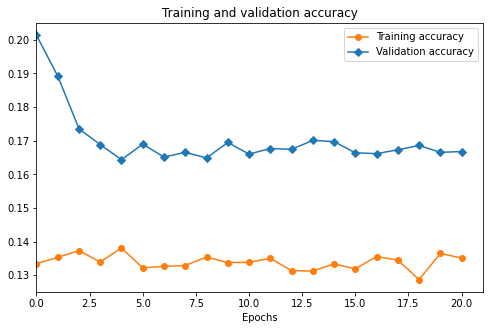

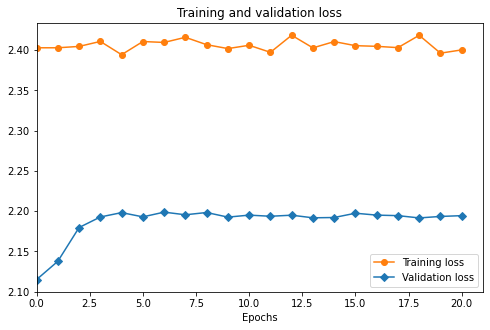

In [190]:
# print accuraccy and loss curves
plot_train_curve(history)

### Confusion Matrix for CNN

              precision    recall  f1-score   support

 -10 or less       0.00      0.00      0.00         3
    -9 to -4       0.05      0.01      0.01       126
    -3 to -1       0.08      0.03      0.04       639
      0 to 3       0.47      0.33      0.39      3657
      4 to 7       0.29      0.12      0.17      2124
     8 to 10       0.08      0.05      0.06       573
    11 to 15       0.06      0.05      0.06       394
    16 to 25       0.03      0.10      0.05       226
         26+       0.01      0.30      0.02        94

    accuracy                           0.20      7836
   macro avg       0.12      0.11      0.09      7836
weighted avg       0.32      0.20      0.24      7836



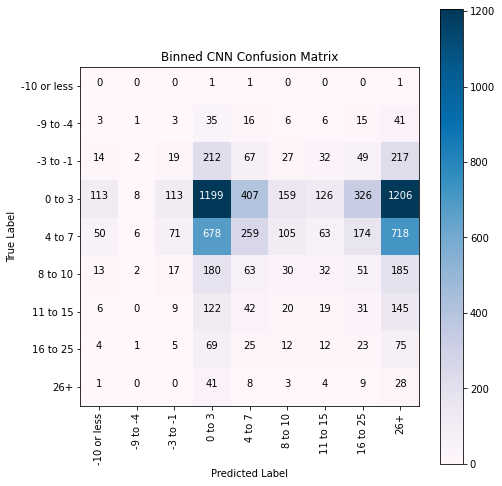

In [191]:
# predict values from test set
y_bin_pred = bin_model.predict(cnn_testX)
# convert predictions classes to one hot vectors
y_bin_pred_classes = np.argmax(y_bin_pred, axis = 1)
# convert test labels to one hot vectors
y_bin_true = np.argmax(bin_cnn_testY, axis = 1)
# compute confusion matrix
cm = confusion_matrix(y_bin_true, y_bin_pred_classes)
# plot confusion matrix
plot_CM(cm = cm, 
        classes = bin_yard_names,
        normalize = False,
        title = 'Binned CNN Confusion Matrix')
print(classification_report(y_bin_true, y_bin_pred_classes,
                            target_names = bin_yard_names))

# Random Forest

## All Variables

In [0]:
# predict binned yards
bin_rf = RandomForestClassifier(n_estimators = 100, # number of trees
                           min_samples_split = 3,
                           oob_score = True)
bin_rf.fit(trainX, bin_trainY)
print('Accuracy: ', round(bin_rf.score(testX, bin_testY)*100,2), '%')


### Confusion Matrix

In [0]:
# predictions
y_pred = bin_rf.predict(testX)
# define confusion matrix
cm = confusion_matrix(bin_testY, y_pred)
# plot cm as a heat map
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'PuBu', fmt = 'd') # fmt = 'd' prints integers
plt.title('Random Forest Confusion Matrix')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 90)
plt.yticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 0)
plt.show()

## Remove Zero Variance Variables

In [0]:
# remove zero variance colomns
zero_var = []
for col in trainX.columns:
  if trainX[col].std() != 0:
    zero_var.append(col)

rf_trainX = trainX[zero_var]
rf_testX = testX[zero_var]

In [212]:
# predict binned yards
rf = RandomForestClassifier(n_estimators = 100, # number of trees
                           min_samples_split = 3,
                           oob_score = True)
rf.fit(rf_trainX, bin_trainY)
print('Accuracy: ', round(rf.score(rf_testX, bin_testY)*100,2), '%')


Accuracy:  45.44 %


### Confusion Matrix

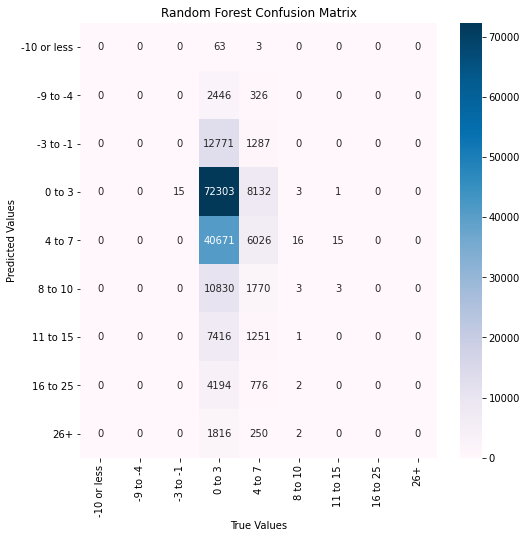

In [213]:
# predictions
y_pred = rf.predict(rf_testX)
# define confusion matrix
cm = confusion_matrix(bin_testY, y_pred)
# plot cm as a heat map
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'PuBu', fmt = 'd') # fmt = 'd' prints integers
plt.title('Random Forest Confusion Matrix')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 90)
plt.yticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 0)
plt.show()

In [207]:
print(classification_report(bin_testY, y_pred, target_names = bin_yard_names, zero_division = 0))

              precision    recall  f1-score   support

 -10 or less       0.00      0.00      0.00        66
    -9 to -4       0.00      0.00      0.00      2772
    -3 to -1       0.00      0.00      0.00     14058
      0 to 3       0.47      0.91      0.62     80454
      4 to 7       0.32      0.13      0.18     46728
     8 to 10       0.12      0.00      0.00     12606
    11 to 15       0.00      0.00      0.00      8668
    16 to 25       0.00      0.00      0.00      4972
         26+       0.00      0.00      0.00      2068

    accuracy                           0.46    172392
   macro avg       0.10      0.12      0.09    172392
weighted avg       0.32      0.46      0.34    172392

